In [1]:
import networkx as nx
import pandas as pd
import os
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read edges
topology = open('Sprint/topology.txt', 'r')
lines = topology.readlines()
 
edges = []
# Strips the newline character
for line in lines[1:-1]:
    to_node, from_node, cap, _ = line.split()
    edges.append((int(from_node), int(to_node), int(cap)))

In [3]:
# generate graph
G = nx.Graph() #undirected graph since all edges are bidirectional and have shared capacity
G.add_weighted_edges_from(edges)

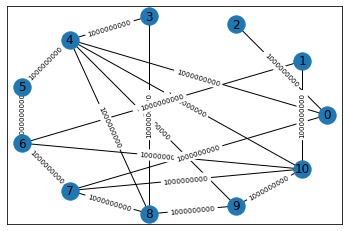

In [4]:
# VISUALIZATION
angles = np.linspace(0, 2*np.pi, 12)[:-1]
coords = [[np.cos(angles[i]), np.sin(angles[i])] for i in range(len(angles))]
pos = {}
for i in range(11):
    pos[i] = coords[i]

nx.draw_networkx(G,pos)
capacities = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=capacities, font_size=7)
plt.savefig("capacities.png", dpi=1000)

In [5]:
# read demands
demand = open('Sprint/demand.txt', 'r')
lines = demand.readlines()
demands = []

for line in lines:
    demands.append(line.split())

demands = np.array(demands, dtype = float)
demands = np.max(demands, axis=0) #use the maximum demand over all times (rows) for each node-node pair

demand = [float(i) for i in line.split()]
n = int(len(demand)**0.5)
demand = np.array(demands).reshape(n, n)
np.fill_diagonal(demand, 0) #demand from a node to itself should be 0

In [6]:
# maximize total throughput
# update edges
edges_undirected = []
for u, v in G.edges():
    tail = min(u,v)
    head = max(u,v)
    edges_undirected.append((tail, head, G[u][v]['weight']))

paths = []
for i in range(n):
    for j in range(n):
        if i != j:
            paths.extend(list(nx.all_simple_edge_paths(G, i, j)))

# Create a new model
m = gp.Model("Max Throughput")

edges_vars = {} # maps edge to (edge var, [path vars that use it])
for (src, dest, capacity) in edges_undirected:
    tail = min(src, dest)
    head = max(src, dest)
    edges_vars[(tail, head)] = (m.addVar(name=f'({tail}, {head})'), [])
    m.addConstr(edges_vars[(tail, head)][0] <= capacity, f'({tail}, {head})<={capacity}') # gurobipy automatically adds >= 0

demand_vars = {} # maps demand between two nodes to the path variables that constitute it

for i in range(n):
    for j in range(n):
        demand_vars[(i, j)] = (demand[i][j],[])

objective = 0 # accumulate the objective we want to optimize (total flow = sum of path flow variables)

for path in paths:
    p = m.addVar(name=f'{path}')
    objective += p

    # add paths that try to satisfy a specific demand
    src, dest = path[0][0], path[-1][-1]
    demand_vars[(src, dest)][1].append(p)

    # this path uses edges --> need to 'credit' the edge
    for (node1, node2) in path:
        tail = min(node1, node2)
        head = max(node1, node2)
        edges_vars[(tail, head)][1].append(p)

# relating edge to path variables
for key in edges_vars:
    m.addConstr(edges_vars[key][0] == sum(edges_vars[key][1]))

# do not send more than what is demanded
for key in demand_vars:
    if demand_vars[key][1]:
        m.addConstr(sum(demand_vars[key][1]) <= demand_vars[key][0])

# Set objective
m.setObjective(objective, GRB.MAXIMIZE)

# Optimize model
m.optimize()

# for v in m.getVars():
#     print('%s %g' % (v.VarName, v.X))

print('Obj: %g' % m.ObjVal)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-17
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 146 rows, 4192 columns and 28210 nonzeros
Model fingerprint: 0xbcde3cef
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+09]
Presolve removed 146 rows and 4192 columns
Presolve time: 0.03s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.5364596e+07   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.04 seconds (0.01 work units)
Optimal objective  2.536459622e+07
Obj: 2.53646e+07


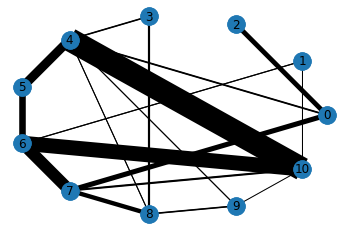

In [7]:
# VISUALIZATION of edge flow by size
# get edge flows
flows = {}
modelVars = m.getVars()
for i in range(len(G.edges())):
    var = modelVars[i]
    edge = eval(var.VarName)
    flows[edge] = var.X
nx.set_edge_attributes(G, flows, "flow")
nx.draw_networkx(G,pos)

widths = []
for u,v in G.edges():
    widths.append(G[u][v]['flow'] / G[u][v]['weight']*1000)

nx.draw(G, pos, width=widths)
plt.savefig("max_flow_widths.png", dpi=1000)

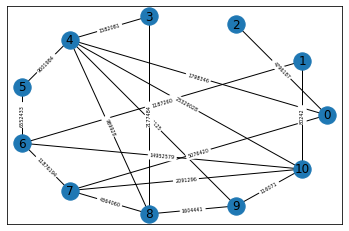

In [8]:
# visualization with edge flow / capacity
nx.draw_networkx(G,pos)

# get edge widths
labels = {}
for u,v in G.edges():
    labels[(u,v)] = str(round(G[u][v]['flow']))

nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, font_size=5)
plt.savefig("max_flow.png", dpi=1000)

In [9]:
# Minimize the MLU (changing the objective function)

flow = 0 # represents the total flow sent on this network

paths = []
for i in range(n):
    for j in range(n):
        if i != j:
            paths.extend(list(nx.all_simple_edge_paths(G, i, j)))

# Create a new model
m = gp.Model("Min MLU - flow")

# new variable for current MLU
MLU = m.addVar(name="MLU")

edges_vars = {} # maps edge to (edge var, [path vars that use it])
for (src, dest, capacity) in edges_undirected:
    tail = min(src, dest)
    head = max(src, dest)
    edges_vars[(tail, head)] = (m.addVar(name=f'({tail}, {head})'), [])
    m.addConstr(edges_vars[(tail, head)][0] <= capacity, f'({src}, {tail})<={head}') # >= 0 is already added
    m.addConstr(edges_vars[(tail, head)][0] / capacity <= MLU)

demand_vars = {} # maps demand between two nodes to the path variables that constitute it

n = len(demand)
for i in range(n):
    for j in range(n):
        demand_vars[(i, j)] = (demand[i][j],[])


for path in paths:
    p = m.addVar(name=f'{path}')
    flow += p # add this path flow to our total flow accumulator

    # add paths that try to satisfy a specific demand
    src, dest = path[0][0], path[-1][-1]
    demand_vars[(src, dest)][1].append(p)

    # this path uses edges --> need to 'credit' the edge
    for (node1, node2) in path:
        tail = min(node1, node2)
        head = max(node1, node2)
        edges_vars[(tail, head)][1].append(p)

# relating edge to path variables
for key in edges_vars:
    m.addConstr(edges_vars[key][0] == sum(edges_vars[key][1]))

# do not send more than what is demanded
for key in demand_vars:
    if demand_vars[key][1]:
        m.addConstr(sum(demand_vars[key][1]) <= demand_vars[key][0])

# create a variable for the total flow in the network so we can retrieve its value after solving
total_flow = m.addVar(name="total_flow")
m.addConstr(total_flow == flow)

# Set objective
m.setObjective(MLU - total_flow/np.sum(demands), GRB.MINIMIZE) # minimize MLU but reward satisfying as much demand as possible

# Optimize model
m.optimize()

# for v in m.getVars():
#     print('%s %g' % (v.VarName, v.X))

print('Obj: %g' % m.ObjVal)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 165 rows, 4194 columns and 32421 nonzeros
Model fingerprint: 0x1bacf877
Coefficient statistics:
  Matrix range     [1e-09, 1e+00]
  Objective range  [4e-08, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+09]
Presolve removed 21 rows and 2 columns
Presolve time: 0.03s
Presolved: 144 rows, 4192 columns, 28225 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier performed 0 iterations in 0.06 seconds (0.01 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       1   -8.7454141e-01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.07

In [10]:
print("MLU: ", MLU.X)
print("Total flow: ", total_flow.X)

MLU:  0.02108693121655601
Total flow:  25364596.222414006


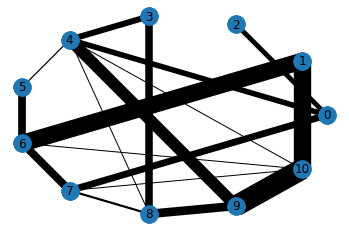

In [11]:
# VISUALIZATION
# get edge flows
flows = {}
modelVars = m.getVars()
for i in range(1, len(G.edges())+1):
    var = modelVars[i]
    edge = eval(var.VarName)
    flows[edge] = var.X
nx.set_edge_attributes(G, flows, "flow")
nx.draw_networkx(G,pos)
widths = []
for u,v in G.edges():
    widths.append(G[u][v]['flow'] / G[u][v]['weight']*1000)
nx.draw(G, pos, width=widths)
plt.savefig("MLU_v1_widths.png", dpi=1000)

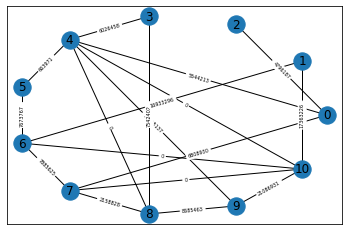

In [12]:
# visualization with edge flow / capacity
nx.draw_networkx(G,pos)

# get edge widths
labels = {}
for u,v in G.edges():
    labels[(u,v)] = str(round(G[u][v]['flow']))

nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, font_size=5)
plt.savefig("MLU_v1.png", dpi=1000)

In [13]:
# Minimize MLU (adding a constraint)

flow = 0 # represents the total flow sent on this network

paths = []
for i in range(n):
    for j in range(n):
        if i != j:
            paths.extend(list(nx.all_simple_edge_paths(G, i, j)))

# Create a new model
m = gp.Model("Min MLU with constraint")

# new variable for MLU
MLU = m.addVar(name="MLU")

edges_vars = {} #maps edge to (edge var, [path vars that use it])
for (src, dest, capacity) in edges_undirected:
    tail = min(src, dest)
    head = max(src, dest)
    edges_vars[(tail, head)] = (m.addVar(name=f'({tail}, {head})'), [])
    m.addConstr(edges_vars[(tail, head)][0] <= capacity, f'({src}, {tail})<={head}') # >= 0 is already added
    m.addConstr(edges_vars[(tail, head)][0] / capacity <= MLU)

demand_vars = {} # maps demand between two nodes to the path variables that constitute it

n = len(demand)
for i in range(n):
    for j in range(n):
        demand_vars[(i, j)] = (demand[i][j],[])

for path in paths:
    p = m.addVar(name=f'{path}')
    flow += p # add this path flow to our total flow accumulator

    # add paths that try to satisfy a specific demand
    src, dest = path[0][0], path[-1][-1]
    demand_vars[(src, dest)][1].append(p)

    # this path uses edges --> need to 'credit' the edge
    for (node1, node2) in path:
        tail = min(node1, node2)
        head = max(node1, node2)
        edges_vars[(tail, head)][1].append(p)

#relating edge to path variables
for key in edges_vars:
    m.addConstr(edges_vars[key][0] == sum(edges_vars[key][1]))

# do not send more than what is demanded
for key in demand_vars:
    if demand_vars[key][1]:
        m.addConstr(sum(demand_vars[key][1]) >= demand_vars[key][0])

# create a variable for the total flow in the network so we can retrieve its value after solving
total_flow = m.addVar(name="total_flow")
m.addConstr(total_flow == flow)

# Set objective
m.setObjective(MLU, GRB.MINIMIZE)

# Optimize model
m.optimize()

# for v in m.getVars():
#     print('%s %g' % (v.VarName, v.X))

print('Obj: %g' % m.ObjVal)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 165 rows, 4194 columns and 32421 nonzeros
Model fingerprint: 0x0b42ba9b
Coefficient statistics:
  Matrix range     [1e-09, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+09]
Presolve removed 21 rows and 3 columns
Presolve time: 0.01s
Presolved: 144 rows, 4191 columns, 28224 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.178e+03
 Factor NZ  : 3.090e+03 (roughly 2 MB of memory)
 Factor Ops : 7.795e+04 (less than 1 second per iteration)
 Threads    : 1

Barrier performed 0 iterations in 0.03 seconds (0.01 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual

In [14]:
print("MLU: ", m.ObjVal)
print("Total flow: ", total_flow.X)

MLU:  0.006492860504387
Total flow:  25364596.222414006


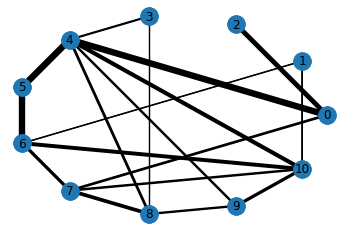

In [15]:
# VISUALIZATION
# get edge flows
flows = {}
modelVars = m.getVars()
for i in range(1, len(G.edges())+1):
    var = modelVars[i]
    edge = eval(var.VarName)
    flows[edge] = var.X
nx.set_edge_attributes(G, flows, "flow")
nx.draw_networkx(G,pos)
widths = []
for u,v in G.edges():
    widths.append(G[u][v]['flow'] / G[u][v]['weight']*1000)
nx.draw(G, pos, width=widths)
plt.savefig("MLU_v2_widths.png", dpi=1000)

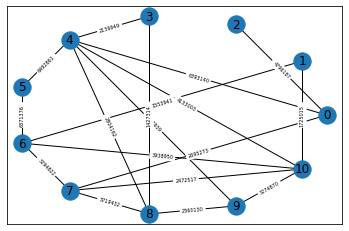

In [16]:
# visualization with edge flow / capacity
nx.draw_networkx(G,pos)

# get edge widths
labels = {}
for u,v in G.edges():
    labels[(u,v)] = str(round(G[u][v]['flow']))

nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, font_size=5)
plt.savefig("MLU_v2.png", dpi=1000)